In [29]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
from datasets import load_dataset, load_metric
import numpy as np
import matplotlib.pyplot as plt

# Task 1 

## Delivrable 1.1

In [30]:
tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")
max_length = 512

#### T5 for Translation

In [31]:
dataset_translation = load_dataset("bible_para", lang1="en", lang2="fr") #translation 

# exemple on a sample
fr_sentence = dataset_translation['train'][0]['translation']['fr']    # train is the only split available
en_sentence = dataset_translation['train'][0]['translation']['en']

prefix_translation = 'translate English to French:'
input_ids = tokenizer(prefix_translation + en_sentence, return_tensors="pt", max_length=max_length, truncation=True).input_ids
output = model.generate(input_ids=input_ids)

print('T5 for translation - example :')
print('INPUT:', en_sentence)
print('OUTPUT:', tokenizer.decode(output[0], skip_special_tokens=True))
print('GROUND TRUTH:', fr_sentence)

Using custom data configuration en-fr-lang1=en,lang2=fr
Reusing dataset bible_para (C:\Users\ANTOINE\.cache\huggingface\datasets\bible_para\en-fr-lang1=en,lang2=fr\0.0.0\b6cc20bcbfb0299beeba1dcc80a8420b975938ca0eef75b3ed30b50df7d950b1)
100%|██████████| 1/1 [00:00<00:00, 18.70it/s]


T5 for translation - example :
INPUT: In the beginning God created the heavens and the earth.
OUTPUT: Au début, Dieu créa les cieux et la terre.
GROUND TRUTH: Au commencement, Dieu créa les cieux et la terre.


#### T5 for summarization

In [47]:
dataset_summary = load_dataset("cnn_dailymail", "1.0.0", split="test[:10%]")  # evaluating the model on the test set

# exemple on a sample
article = dataset_summary[4]['article']
summary = dataset_summary[4]['highlights']

prefix_summary = 'summarize:'
input_ids = tokenizer(prefix_summary + article, return_tensors="pt", max_length=max_length, truncation=True).input_ids
output = model.generate(input_ids=input_ids)

print('T5 for summarization - example :')
print('INPUT:', article[:512])
print('OUTPUT:', tokenizer.decode(output[0], skip_special_tokens=True))
print('GROUND TRUTH:', summary)

Reusing dataset cnn_dailymail (C:\Users\ANTOINE\.cache\huggingface\datasets\cnn_dailymail\1.0.0\1.0.0\3cb851bf7cf5826e45d49db2863f627cba583cbc32342df7349dfe6c38060234)


T5 for summarization - example :
INPUT: (CNN)Marco Rubio is all in.  The Republican senator from Florida has announced that he is seeking the Republican presidential nomination, running on an optimistic message that he embodies the promise of the American Dream. With his youthful energy and Hispanic roots, it's tempting to see Rubio as the new blood that the GOP needs in order to compete against Hillary Clinton in 2016.  Yet Rubio has been his own worst enemy on what could have been his two signature issues: immigration reform and Cuba relations.
OUTPUT: marco Rubio is seeking the Republican presidential nomination. he says he has been
GROUND TRUTH: Raul Reyes: In seeking Latino vote, Marco Rubio his own worst enemy on two key issues: immigration reform, Cuba relations . He says on health care, climate change and other issues, he breaks from Latinos' positions. Polls show they don't favor him .


#### T5 for question answering

In [ ]:
dataset_qa = load_dataset("boolq") 

# exemple on a sample
for i in range(4) : 
    question = dataset_qa['validation'][i]['question'] # evaluating the model on the val set
    answer = dataset_qa['validation'][i]['answer']

    prefix_qa = 'question:'
    input_ids = tokenizer(prefix_qa + question, return_tensors="pt", max_length=max_length, truncation=True).input_ids

    output = model.generate(input_ids=input_ids)
    print('T5 for question answering - example :')
    print('INPUT:', question)
    print('OUTPUT:', tokenizer.decode(output[0], skip_special_tokens=True))
    print('GROUND TRUTH:', answer)

Using custom data configuration default
Reusing dataset boolq (C:\Users\ANTOINE\.cache\huggingface\datasets\boolq\default\0.1.0\bf0dd57da941c50de94ae3ce3cef7fea48c08f337a4b7aac484e9dddc5aa24e5)
100%|██████████| 2/2 [00:00<00:00, 100.27it/s]


INPUT: does ethanol take more energy make that produces
OUTPUT: ethanol
GROUND TRUTH: False


INPUT: is house tax and property tax are same
OUTPUT: same
GROUND TRUTH: True


INPUT: is pain experienced in a missing body part or paralyzed area
OUTPUT: paralyzed area
GROUND TRUTH: True


INPUT: is harry potter and the escape from gringotts a roller coaster ride
OUTPUT: roller coaster ride
GROUND TRUTH: True




We can see that T5  anwsers correctly to some of the questions. However, since the labels are booleans and not plain text, **we cannot compute any scores (ROUGE/BLEU) for this task**. 

## Delivrable 1.2

#### Implementing BLEU

In [34]:
# implementation of BLEU 
def get_n_grams(segment, n) : 
    counts = {}
    total = 0
    for i in range(len(segment) - n + 1):
        n_gram = tuple(segment[i:i + n])
        if n_gram in counts.keys() : 
            counts[n_gram] += 1
        else : 
            counts[n_gram] = 1
        total += 1 
    return counts


def get_adapted_precision(counts, counts_true) : 
    'compute adapted precision for infered n-grams and true n-grams'
    total = 0
    for n_gram in counts.keys() : 
        total += counts[n_gram]
    if total == 0 :
        return 0

    precision = 0
    for n_gram in counts.keys() : 

        nb_occurance = counts[n_gram]
        if n_gram in counts_true.keys() : 
            nb_occurance_true = counts_true[n_gram]
        else : 
            nb_occurance_true = 0
        nb_occurance_clipped = min(nb_occurance, nb_occurance_true)
        precision += nb_occurance_clipped

    return precision / total


def BLEU(segment, segment_true, n_max = 4) :
    'compute the BLEU metric with uniform weighting'

    #compute BP factor
    c = len(segment) 
    r = len(segment_true)
    BP = np.exp(1 - r/c) if c <= r else 1 

    # compute geometric mean of n-grams adapted precisions
    geometric_mean = 1
    for n in range(n_max) : 
        counts = get_n_grams(segment, n)
        counts_true = get_n_grams(segment_true, n)
        geometric_mean *= get_adapted_precision(counts, counts_true)

    if geometric_mean == 0 :
        return 0
    else : 
        return BP * np.exp( 1/n_max * np.log(geometric_mean))

#### Implementing ROUGE

In [35]:

# implementation of ROUGE
def get_precision(counts, counts_true) : 
    'compute adapted precision for infered n-grams and true n-grams'
    total = 0
    for n_gram in counts.keys() : 
        total += counts[n_gram]

    if total == 0 :
        return 0 
        
    precision = 0
    for n_gram in counts.keys() : 

        nb_occurance = counts[n_gram]
        if n_gram in counts_true.keys() : 
            precision += nb_occurance 

    return precision / total

def get_recall(counts, counts_true) : 
    total_true = len(list(counts_true.keys())) 

    recall = 0
    for n_gram in counts.keys() : 
        if n_gram in counts_true.keys() : 
            recall += 1 

    return recall / total_true

def ROUGE_N(segment, true_segment, n) : 
    'compute the ROUGE-N metric : recall using n-grams'
    counts = get_n_grams(segment, n)
    counts_true = get_n_grams(true_segment, n)
    precision = get_precision(counts, counts_true)
    recall = get_recall(counts, counts_true)

    denum = precision + recall
    if denum == 0 : 
        return (0, 0, 0)
    f1 = precision * recall / denum
    return precision, recall, f1

def lcs(segment_A, segment_B):
    'compute longuest common sequence using dynamic programming'
    p = len(segment_A)
    q = len(segment_B)
    temp = np.zeros((p+1, q+1))
    for i in range(p + 1):
        for j in range(q + 1):
            if i == 0 or j == 0 :
                temp[i, j] = 0
            elif segment_A[i-1] == segment_B[j-1]:
                temp[i, j] = temp[i-1, j-1]+1
            else:
                temp[i, j] = max(temp[i-1, j], temp[i, j-1])
    return temp[p, q]
    
def ROUGE_L(segment, true_segment) : 
    'compute the ROUGE-L metric : longest common subsequence'
    return lcs(segment, true_segment) / len(true_segment)


# other
def tokenize(sentence) : 

    unwanted_char = ['|','?','_','!','¶','€',':',']','\t','^',
                '/','*','}','$','~','&','{','[','(','"',
                '`','=',';','@','+','%',')','>','.',',',
                '\\','"','£','\n','-']

    for char in unwanted_char:
        sentence = sentence.replace(char, '')

    return sentence.lower().strip().split(' ')

#### Comparison of our implementation of ROUGE and BLEU vs an existing and documented implementation

In [40]:
def init():
    scores = {
        'rouge1' : [],
        'rouge2' : [], 
        'rougeL' : [], 
        'bleu' : []
    }

    true_scores = {
        'rouge1' : [],
        'rouge2' : [], 
        'rougeL' : [], 
        'bleu' : []
    }

    BLEU_ = load_metric("bleu")
    ROUGE_ = load_metric("rouge")

    return scores, true_scores, BLEU_, ROUGE_


def main_loop(prefix, input, label, scores, true_scores, ROUGE_, BLEU_) : 
    input_ids = tokenizer(prefix + input, return_tensors="pt", max_length=max_length, truncation=True).input_ids
    output = model.generate(input_ids=input_ids)
    output = tokenizer.decode(output[0], skip_special_tokens=True)

    output_tokens = tokenize(output)
    true_tokens = tokenize(label)
    scores['rouge1'].append(ROUGE_N(output_tokens, true_tokens, n=1))
    scores['rouge2'].append(ROUGE_N(output_tokens, true_tokens, n=2))
    scores['rougeL'].append(ROUGE_L(output_tokens, true_tokens))
    scores['bleu'].append(BLEU(output_tokens, true_tokens, n_max = 4))


    ROUGE_.add_batch(predictions=[output_tokens], references=[[true_tokens]])
    BLEU_.add_batch(predictions=[output_tokens], references=[[true_tokens]])

    rouge_ = ROUGE_.compute(use_agregator = False)
    bleu_= BLEU_.compute()

    true_scores['rouge1'].append(rouge_['rouge1'][0])
    true_scores['rouge2'].append(rouge_['rouge2'][0])
    true_scores['rougeL'].append(rouge_['rougeL'][0])
    true_scores['bleu'].append(bleu_['bleu'])


def post_process(scores, true_scores) : 
    for dic in [scores, true_scores] : 
        for key in ['rouge1', 'rouge2', 'rougeL', 'bleu'] : 
            dic[key] = np.array(dic[key])
    
    return scores, true_scores


def evaluate_translation(n_iter) : 
    'evaluates the T5 model for translation on the '

    scores,true_scores, BLEU_, ROUGE_ = init()

    for i, data in enumerate(dataset_translation['train']) : # only the train set is available...
        en_sentence = data['translation']['en']
        fr_sentence = data['translation']['fr']
        main_loop(prefix_translation, en_sentence, fr_sentence, scores, true_scores, ROUGE_, BLEU_)

        if i > n_iter - 2 : 
            break

    scores, true_scores = post_process(scores, true_scores)

    return scores, true_scores

def evaluate_summary(n_iter) : 
    'evaluates the T5 model for translation on the '

    scores,true_scores, BLEU_, ROUGE_ = init()

    for i, data in enumerate(dataset_summary) : 
        summary = data['highlights']
        text = data['article']
        main_loop(prefix_summary, text, summary, scores, true_scores, ROUGE_, BLEU_)

        if i > n_iter - 2 : 
            break

    scores, true_scores = post_process(scores, true_scores)

    return scores, true_scores


def correl(A, B) : 
    return A/np.linalg.norm(A)  @ B/np.linalg.norm(B)

def plotting(key, sc, tsc) : 
    plt.title(f'{key} - correlation={correl(sc, tsc):.2f}')
    plt.plot(sc, label = 'ours')
    plt.plot(tsc, label = 'truth')
    plt.legend()
    plt.show()

In [41]:
scores, true_scores = evaluate_translation(n_iter = 15)

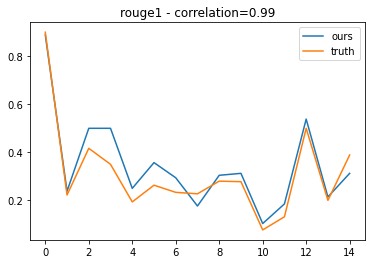

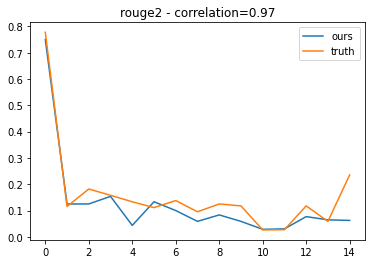

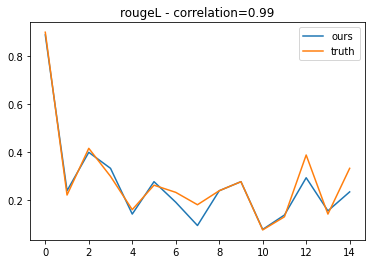

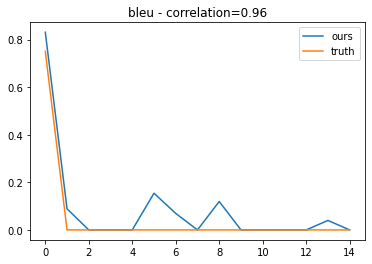

In [43]:
# Here we compare our implentation of ROUGE and BLEU vs the one of Huffingface to ensure that it is properly implemented

for key in ['rouge1', 'rouge2'] : 
    sc = scores[key][:, 1]
    tsc = true_scores[key][:, 1]
    plotting(key, sc, tsc)

key = 'rougeL'
sc = scores[key]
tsc = true_scores[key][:, 1]
plotting(key, sc, tsc)


key = 'bleu'
sc = scores[key]
tsc = true_scores[key]
plotting(key, sc, tsc)

We can see that the metics that we implemented are very close to the true ones as all the correlations are greater than 0.96. It is properly implemented.

#### Evaluation of T5 for translation

In [45]:
scores, true_scores = evaluate_translation(n_iter = 1000)

for key in ['rouge1', 'rouge2'] : 
    sc = scores[key].mean(axis = 0) # taking the score average over the 1000 samples
    sc[2] = sc[0] * sc[1] / (sc[0] + sc[1])#computing f1 score

    print(key.upper())
    print(f'OURS :\n\tprecision: {sc[0]:.2f}\n\trecall: {sc[1]:.2f}\n\tf1: {sc[2]:.2f}')
    print(f'TRUTH:\n\tprecision: {sc[0]:.2f}\n\trecall: {sc[1]:.2f}\n\tf1: {sc[2]:.2f}')
    print('==================')

key = 'rougeL'
sc = scores[key].mean() # taking the score average over the 1000 samples
print('ROUGE-L')
print(f'OURS : {sc:.2f}')
print(f'TRUTH: {sc:.2f}')
print('==================')


key = 'bleu'
sc = scores[key].mean() # taking the score average over the 1000 samples
print(key.upper())
print(f'OURS : {sc:.2f}')
print(f'TRUTH: {sc:.2f}')
print('==================')

ROUGE1
OURS :
	precision: 0.42
	recall: 0.23
	f1: 0.15
TRUTH:
	precision: 0.42
	recall: 0.23
	f1: 0.15
ROUGE2
OURS :
	precision: 0.17
	recall: 0.09
	f1: 0.06
TRUTH:
	precision: 0.17
	recall: 0.09
	f1: 0.06
ROUGE-L
OURS : 0.19
TRUTH: 0.19
BLEU
OURS : 0.06
TRUTH: 0.06


#### Evaluation of T5 for summarization

In [48]:
scores, true_scores = evaluate_summary(n_iter = 1000)

for key in ['rouge1', 'rouge2'] : 
    sc = scores[key].mean(axis = 0) # taking the score average over the 1000 samples
    sc[2] = sc[0] * sc[1] / (sc[0] + sc[1])#computing f1 score

    print(key.upper())
    print(f'OURS :\n\tprecision: {sc[0]:.2f}\n\trecall: {sc[1]:.2f}\n\tf1: {sc[2]:.2f}')
    print(f'TRUTH:\n\tprecision: {sc[0]:.2f}\n\trecall: {sc[1]:.2f}\n\tf1: {sc[2]:.2f}')
    print('==================')

key = 'rougeL'
sc = scores[key].mean() # taking the score average over the 1000 samples
print('ROUGE-L')
print(f'OURS : {sc:.2f}')
print(f'TRUTH: {sc:.2f}')
print('==================')

ROUGE1
OURS :
	precision: 0.41
	recall: 0.16
	f1: 0.12
TRUTH:
	precision: 0.41
	recall: 0.16
	f1: 0.12
ROUGE2
OURS :
	precision: 0.14
	recall: 0.05
	f1: 0.04
TRUTH:
	precision: 0.14
	recall: 0.05
	f1: 0.04
ROUGE-L
OURS : 0.12
TRUTH: 0.12


## Delivrable 1.3

@Axel : c'est vrmt hyper dur j'ai regardé un peu, je dirai que ca prend au moins entre 5 et 8 heures pour faire la première implémentation. J'ai demandé à Antonin et Simon Rouard ils font pas cette question. jte propose qu'on fasse pareil. On est noté sur 12 mais nsm si on fait tout bien on aura 9 est ca sera carré.

# Task 2 

A toi de jouer mon gars!